# Quick start

**NumpyBrain is a micro-kernel SNN simulation framework which coded with native NumPy and accelerated with powerful Numba.** 

In this section, we will give you a brief introduction on how to use NumpyBrain in your 
research project, and tell you how to define you own neuron models.

## Use NumpyBrain to construct a network

Three main objects are provided in ``NumpyBrain``, which are `Neurons`, `Synapses`, and `Monitor`. 
In order to help users easily construct a neural network, plenty of useful functions are provided 
(see the module of [npbrian.utils](https://numpybrain.readthedocs.io/en/latest/apis/utils.html)).
Moreover, popular commonly used [neuron models](https://numpybrain.readthedocs.io/en/latest/apis/neurons.html) 
(such as LIF, HH, Izhikevich model) and [synapse models](https://numpybrain.readthedocs.io/en/latest/apis/synapses.html) 
(such as AMPA, GABAa, GABAb, Gap Junction, Short-term Plasticity) are provided.

With such pre-defined components, creating a network is very easy. For example, if you want to create 
two groups of LIF neurons and add reciprocal excitatory and inhibitory synapses between them, you can
simply write:

1, import package, and set the computation backend you prefer

In [1]:
import numpy as np
import npbrain as nn

nn.profile.set_backend('numba')  # or "numpy"

2, create two neuron groups

In [2]:
lif1 = nn.LIF(500, noise=0.5, method='Ito_milstein')  # or method='euler'
lif2 = nn.LIF(1000, noise=1.1, method='Ito_milstein')

3, create the synapses between them

In [3]:
conn = nn.conn.fixed_prob(lif1.num, lif2.num, prob=0.2)
syn = nn.VoltageJumpSynapse(lif1, lif2, weights=0.2, connection=conn)

4, add ``StateMonitor`` to inspect the dynamics of two neuron groups

In [4]:
mon_lif1 = nn.StateMonitor(lif1, ['V', 'spike'])
mon_lif2 = nn.StateMonitor(lif2, ['V', 'spike'])

5, give `lif1` the constant input `15.` at 50-150 ms, and run the model (with the progress reporting)

In [5]:
net = nn.Network(syn, lif1, lif2, mon1=mon_lif1, mon2=mon_lif2)
net.run(duration=200, inputs=(lif1, 15., (50., 150.)), report=True)

Compilation used 4.3862 ms.
Start running ...
Run 10.0% using 0.014 s.
Run 20.0% using 0.028 s.
Run 30.0% using 0.042 s.
Run 40.0% using 0.057 s.
Run 50.0% using 0.072 s.
Run 60.0% using 0.087 s.
Run 70.0% using 0.102 s.
Run 80.0% using 0.116 s.
Run 90.0% using 0.130 s.
Run 100.0% using 0.144 s.
Simulation is done. 


6, visualize the results

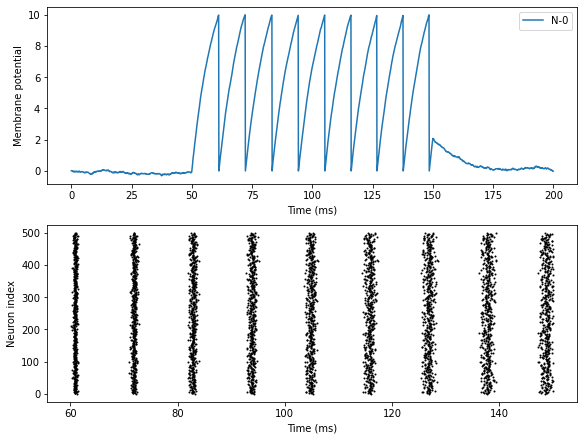

In [7]:
fig, gs = nn.vis.get_figure(n_row=2, n_col=1, len_row=3, len_col=8)
nn.vis.plot_potential(net.mon1, net.run_time(), ax=fig.add_subplot(gs[0, 0]))
nn.vis.plot_raster(net.mon1, net.run_time(), ax=fig.add_subplot(gs[1, 0]), show=True)

In a simulation, ``Network`` organize all the created objects. It's function ``run()`` provides a powerfull 
and flexible way to run you networks. For example, 

- If you want to run the network with 100 ms, just typing

```
net.run(duration=200, inputs=(lif1, 15., (50., 150.)), report=True)
```

- If you want to provide input to `lif1`, for instance, a constant input `11` in the overall 
simulation period (more complex inputs please use 
[npbrain.input_factory](https://numpybrain.readthedocs.io/en/latest/apis/utils.html#input-factory).

```
net.run(100., inputs=(lif1, 11.))
```

- If you want to provide input to `lif1` in the period of 30-50 ms.

```
net.run(100., inputs=(lif1, 11., (30., 50.)))
```

- if you want to provide input to `lif1` in the period of 30-50 ms, and provide input to `lif2` in the period of 10-100 ms.

```
net.run(100., inputs=[(lif1, 11., (30., 50.)), 
                      (lif2, -1., (10., 100.))])
```
- moreover, if you want to repeat run your defined model under different settings (such as different inputs), you can use
```
net.run(100., inputs=(lif1, 11., (30., 50.)), repeat=True)
```

``repeat`` iterm helps you run the same model without re-initialization and re-compilation.

## Use NumpyBrain to define your own model

Once the pre-defined models can not satisfy your interests, you can define your own models. 
``NumyBrain`` provide excellent functions and innovative data management to simplify your model customization.

For example, if you want to define a **leaky integrate-and-fire** (LIF) model, what you need is to provide several key attributes and functions:

In [8]:
def LIF(geometry, tau=100, V_reset=0., Vth=1.):
    var2index = dict(V=0)
    num, geometry = nn.format_geometry(geometry)

    state = nn.initial_neu_state(1, num)
    state[0] = V_reset

    @nn.integrate(method='rk4')
    def int_f(V, t, Isyn):
        return (-V + Isyn) / tau

    def update_state(neu_state, t):
        V_new = int_f(neu_state[0], t, neu_state[-1])
        neu_state[0] = V_new
        spike_idx = nn.judge_spike(neu_state, Vth, t)
        neu_state[0][spike_idx] = V_reset

    return nn.Neurons(**locals())

The essential attributes are

- ``state``: it's a two dimensional matrix which constains the all variables in the neuron model. 
  Each row in the matrix represents a variable of the model. For example, `state[0]` is the 
  variable `V`, `state[-1]` is the neuron input. 
- ``var2index``: it provides the position of each vairbale. Later, it will help you easily get 
  the variable state to record its trajectories.
- ``num`` and ``geometry``: the size of the neuron group. `geometry` is the dimensions of 
  (height, width), `num` is the total number of neurons in the group.

The essential functions are:

- ``update_state()``: it defines how to update the neuron state at the current time-step.

In the above definition of ``LIF``, as you can see, the numerical integration becomes easy, because you just need add a decorator ``nn.integrate`` on the function of the right side of a differential equation. ``NumpyBrain`` implements many [numerical integration algorithms](https://numpybrain.readthedocs.io/en/latest/apis/core.html#numerical-integration-methods), such as `Euler method`, `rk2`, `rk3`, `rk4`, etc. for ordinary differential equations (ODE), and `Euler-Maruyama method`, `Milstein method`, etc. for stachastic differential euqations (SDE). 

Similarly, to define a more complex neuron model, such as Hodgkin–Huxley (HH) model, is also a easy task in ``NumpyBrain`` framework.

In [9]:
def HH(geometry, method=None, noise=0., E_Na=50., g_Na=120., E_K=-77.,
       g_K=36., E_Leak=-54.387, g_Leak=0.03, C=1.0, Vr=-65., Vth=20.):

    var2index = {'V': 0, 'm': 1, 'h': 2, 'n': 3}
    num, geometry = nn.format_geometry(geometry)
    state = nn.initial_neu_state(4, num)

    @nn.integrate(method=method)
    def int_m(m, t, V):
        alpha = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
        beta = 4.0 * np.exp(-(V + 65) / 18)
        return alpha * (1 - m) - beta * m

    @nn.integrate(method=method)
    def int_h(h, t, V):
        alpha = 0.07 * np.exp(-(V + 65) / 20.)
        beta = 1 / (1 + np.exp(-(V + 35) / 10))
        return alpha * (1 - h) - beta * h

    @nn.integrate(method=method)
    def int_n(n, t, V):
        alpha = 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
        beta = 0.125 * np.exp(-(V + 65) / 80)
        return alpha * (1 - n) - beta * n

    @nn.integrate(method=method, noise=noise / C)
    def int_V(V, t, Icur, Isyn):
        return (Icur + Isyn) / C

    def update_state(neu_state, t):
        V, Isyn = neu_state[0], neu_state[-1]
        m = nn.clip(int_m(neu_state[1], t, V), 0., 1.)
        h = nn.clip(int_h(neu_state[2], t, V), 0., 1.)
        n = nn.clip(int_n(neu_state[3], t, V), 0., 1.)
        INa = g_Na * m * m * m * h * (V - E_Na)
        IK = g_K * n ** 4 * (V - E_K)
        IL = g_Leak * (V - E_Leak)
        Icur = - INa - IK - IL
        V = int_V(V, t, Icur, Isyn)
        neu_state[0] = V
        neu_state[1] = m
        neu_state[2] = h
        neu_state[3] = n
        nn.judge_spike(neu_state, Vth, t)

    return nn.Neurons(**locals())

Here, four differential equations exist in the HH model, which are `m`, `h`, `n` channels and membrane potential `V`. For the implementation of variable `V`, `noise` term is provided, and ``NumpyBrain`` will automatically transform it into a SDE. Here, `noise` is a constant. However, it can also receive a complex function.

Finally, after your own difinition, these defined models can also be added in an instance of `Network`. 